## Visualization of Robot missions

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import haversine as hs
from haversine import Unit
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec

/tmp/ipykernel_577248/2375561344.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
input_data_folder_base = Path("../results/")
input_data_folder = Path.cwd() / input_data_folder_base
overall_collection_file_name = "overall_collection_2023.p"
key_parameter_file_name = "key_parameter_2023.p"
print(f"Reading raw pandas files from \n    {input_data_folder}")

output_folder_base = Path("../html/")
output_image_folder = output_folder_base / Path("./images/")
print(f"Writing website information to \n    {output_folder_base}")

Reading raw pandas files from 
    /home/sebastian/Nextcloud/Projekte/2021_DAAD_Brasilien/2023/RoBiMo_Trop_DataSet/notebooks/../results
Writing website information to 
    ../html


In [3]:
df_results = pd.read_pickle(input_data_folder / overall_collection_file_name)
df_results.head(3)


,lat_est,lon_est,yaw_est,hdop,nsats,lat_meas,lon_meas,depth,experiment_location,meas_running,...,CO2(ppm),airtemp in(degreeC),humidity in(rH),pressure in(mbar),airtemp out(degreeC),humidity out(rH),pressure out(mbar),PAR(umol m-2s-1),H2O temp(degreeC),position
datetime_AMT,,,,,,,,,,,,,,,,,,,,,
2023-03-04 20:00:00,-3.290738,-60.164893,111.314,2.59,6.0,-3.290751,-60.164883,7.617662,Iranduba,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-11 18:30:37,-3.290886,-60.165142,162.084,0.83,15.0,-3.290886,-60.165141,5.512197,Iranduba,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-11 18:30:38,-3.290886,-60.165140,172.000,0.78,17.0,-3.290886,-60.165140,5.475826,Iranduba,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(18585, 21)


(16690, 21)


(20940, 21)


(18459, 21)


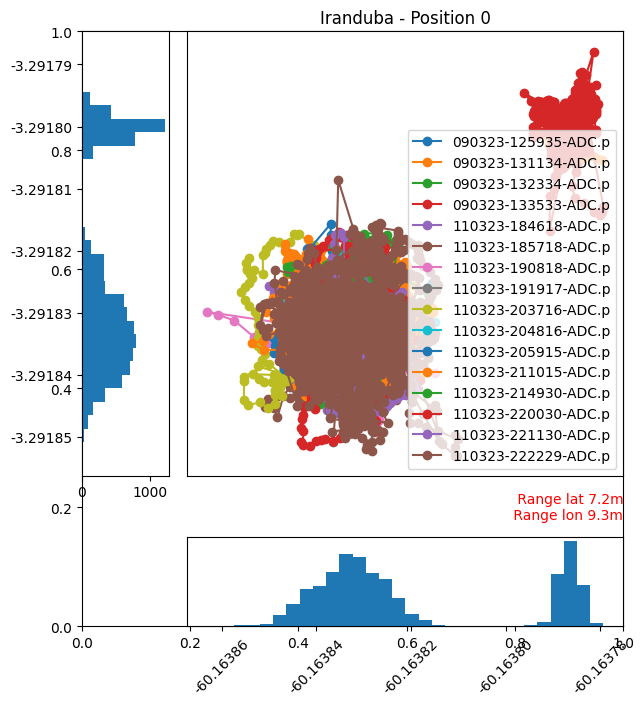

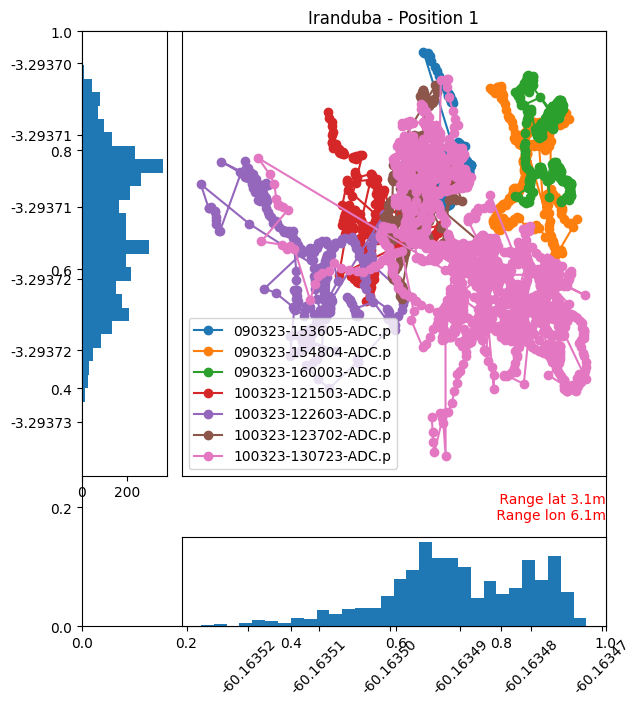

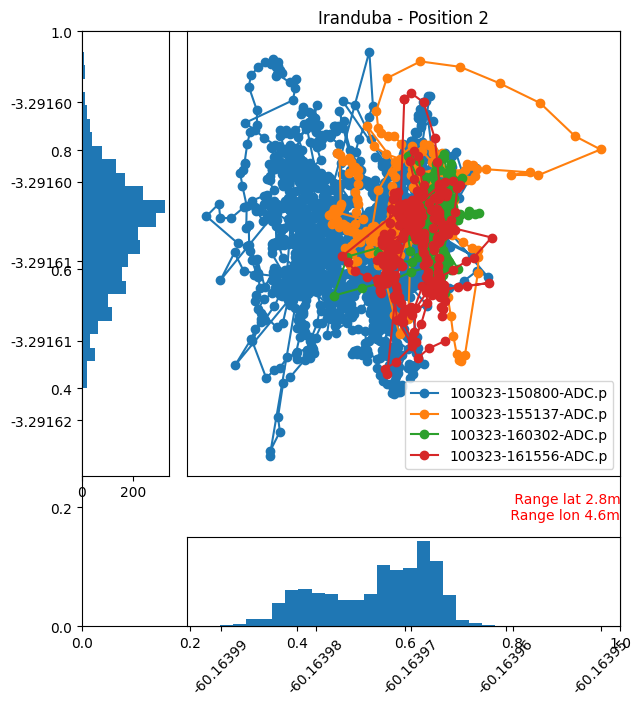

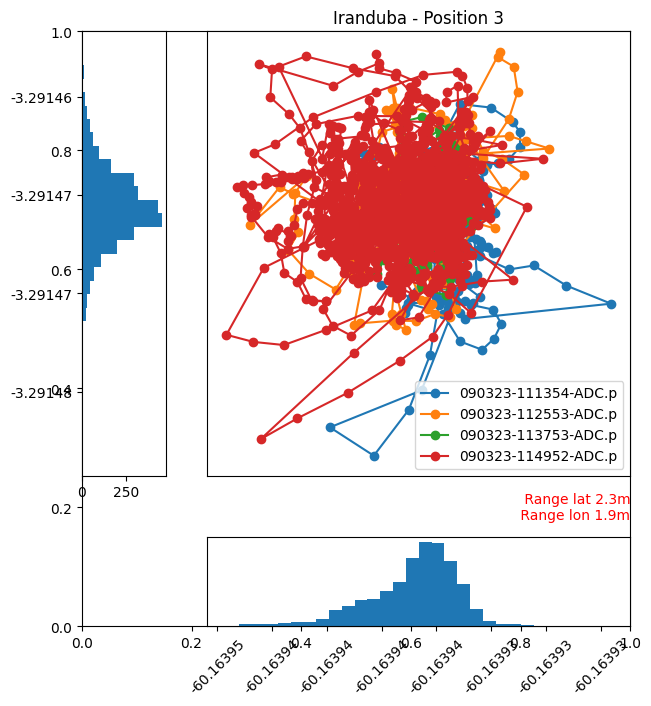

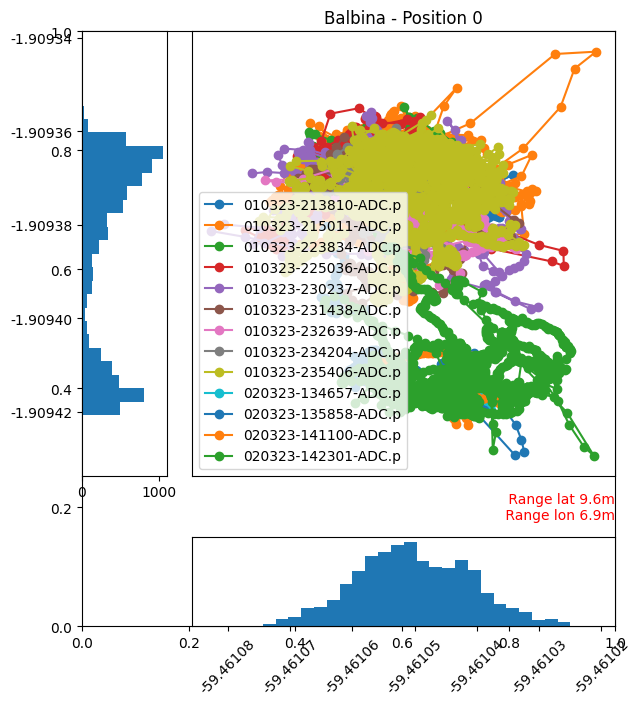

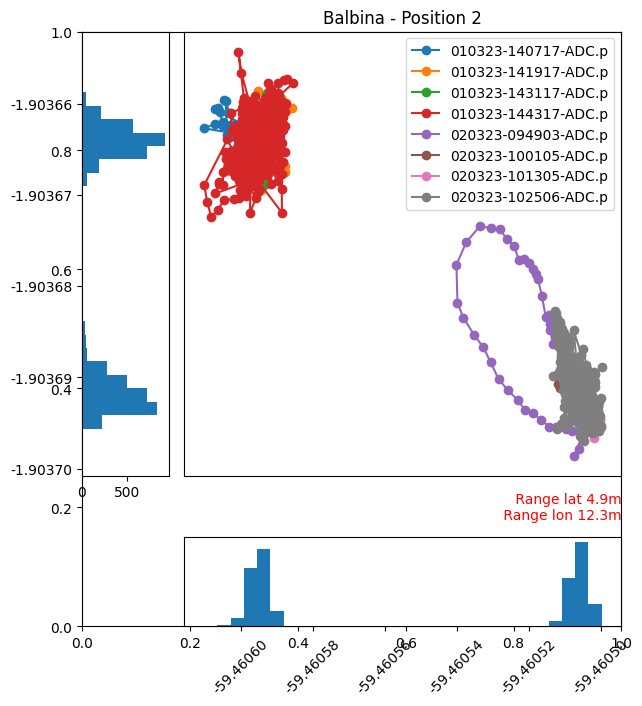

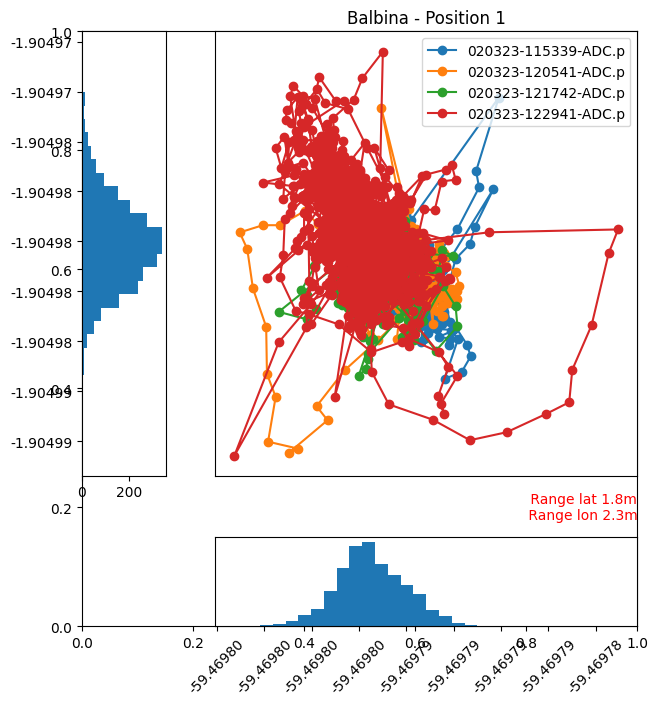

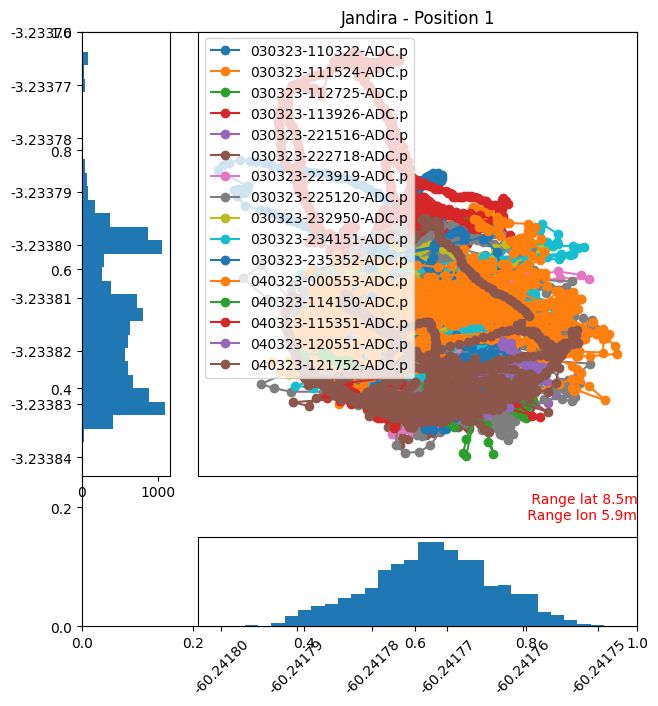

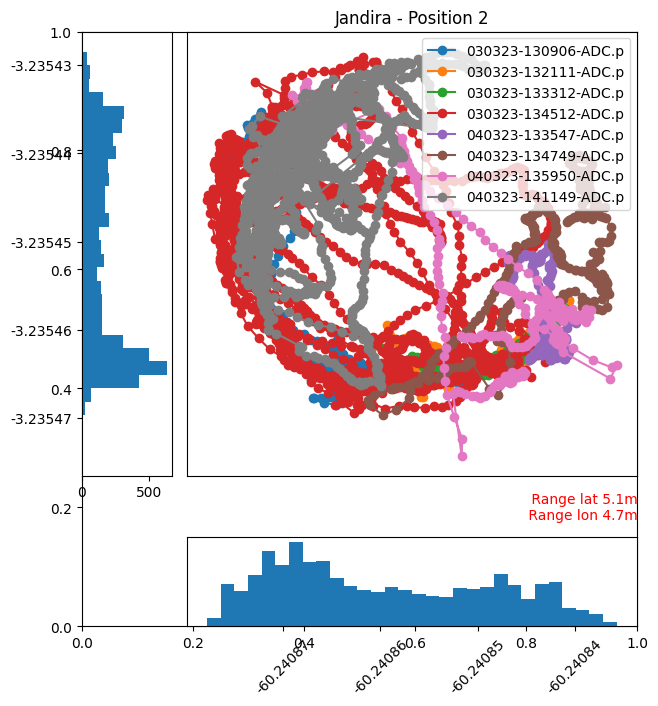

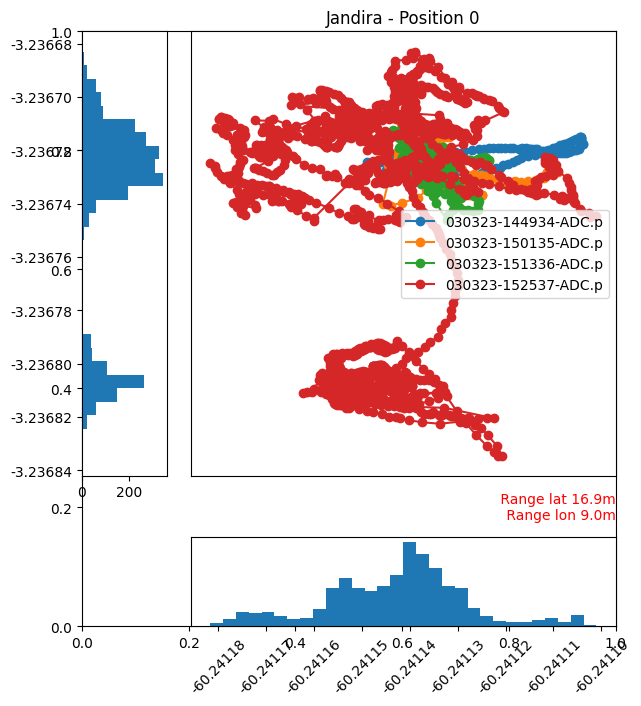

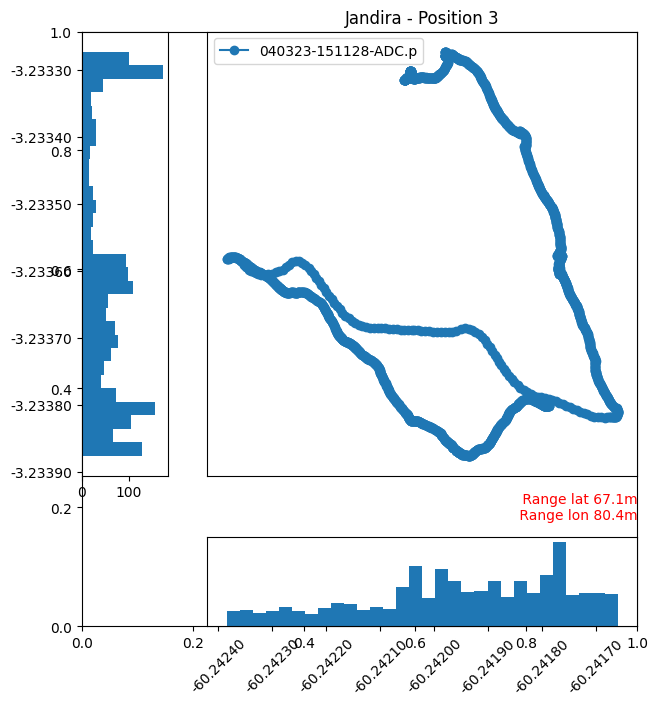

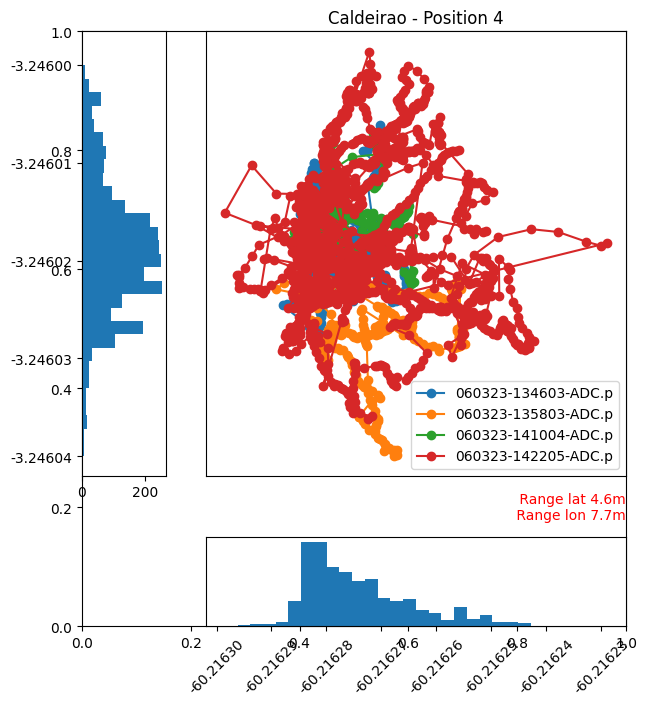

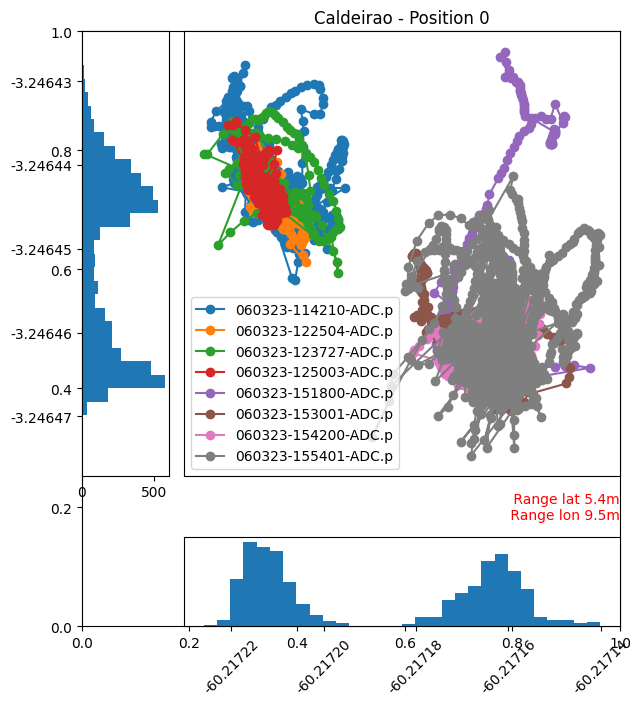

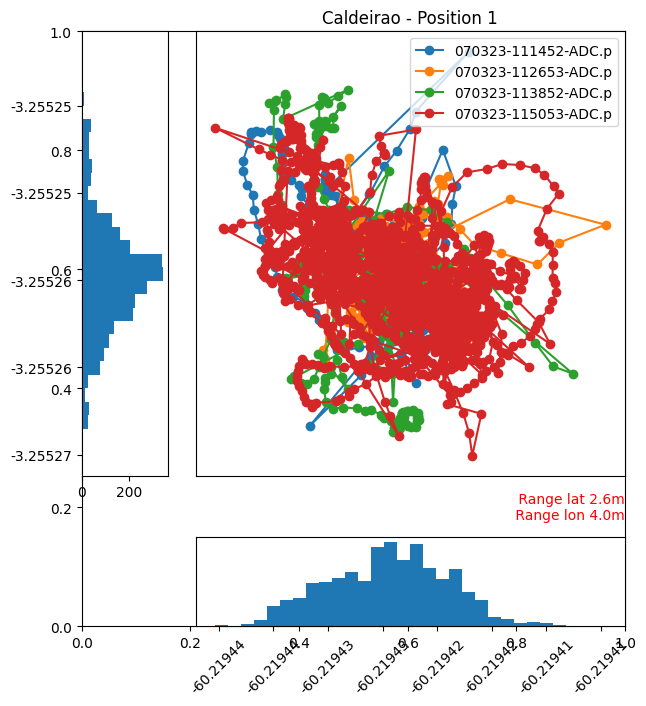

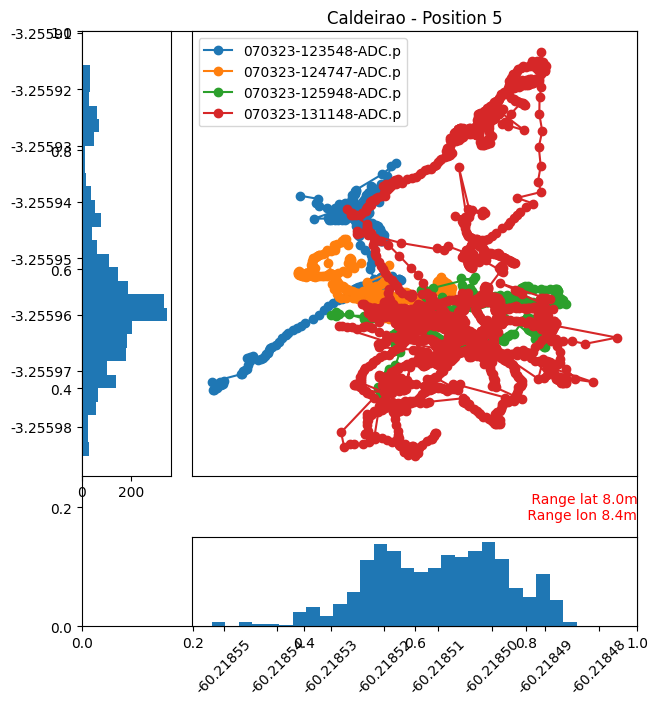

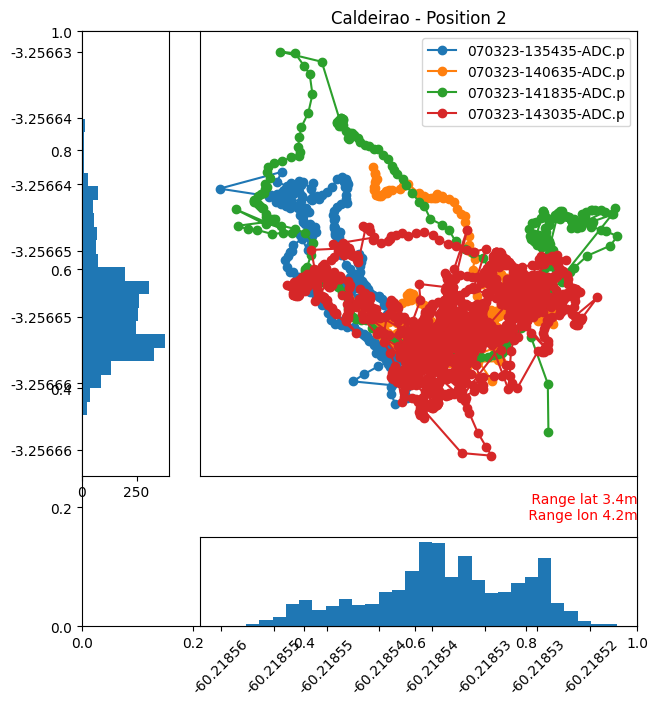

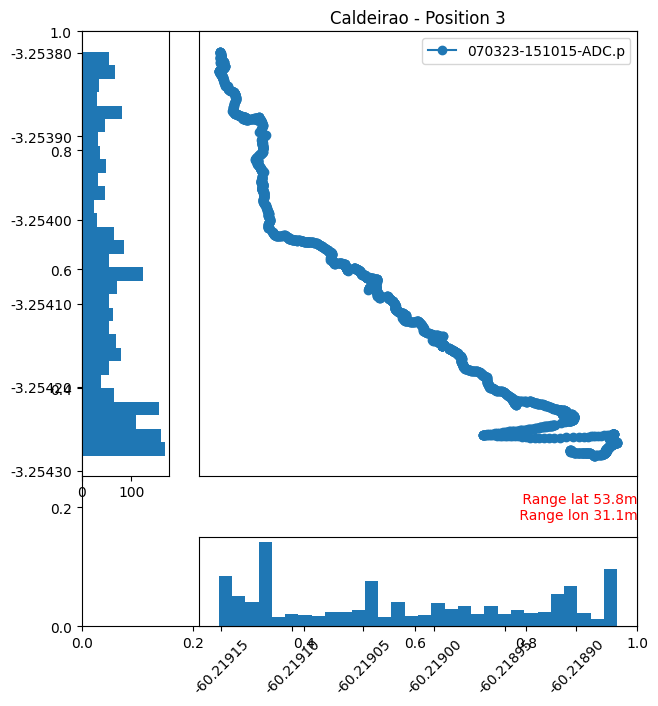

In [4]:
for location_name in df_results.experiment_location.unique():
    df_sep_pos = df_results[(df_results.experiment_location == location_name) &
                            (df_results.meas_running)]
    print(df_sep_pos.shape)

    for index, entry in enumerate(df_sep_pos.position.unique()):
        fig, ax = plt.subplots(figsize=(7, 7))
        gs = gridspec.GridSpec(2, 2,
                            width_ratios=[1, 5],
                            height_ratios=[5, 1])

        ax_vertical_hist = plt.subplot(gs[0])
        ax_main_plot = plt.subplot(gs[1])
        ax_horizontal_hist = plt.subplot(gs[3])

        measurement = df_sep_pos[df_sep_pos.position == entry]
        lat = measurement.lat_est
        lon = measurement.lon_est

        max_long = measurement.lon_est.max()
        min_long = measurement.lon_est.min()
        max_lat = measurement.lat_est.max()
        min_lat = measurement.lat_est.min()
                                # (lat, lon)
        dist_long = hs.haversine((max_lat, min_long),
                                (max_lat, max_long),
                                unit=Unit.METERS)
        dist_lat  = hs.haversine((max_lat, min_long),
                                (min_lat, min_long),
                                unit=Unit.METERS)
        
        ax_vertical_hist.hist(lat, orientation='horizontal', bins=30)
        ax_horizontal_hist.hist(lon, bins=30)
        ax_vertical_hist.yaxis.set_major_formatter(FormatStrFormatter('% .5f'))
        ax_horizontal_hist.yaxis.set_major_formatter(FormatStrFormatter('% .5f'))
        ax_horizontal_hist.xaxis.set_major_formatter(FormatStrFormatter('% .5f'))
        ax_horizontal_hist.get_yaxis().set_visible(False)

        groups = measurement.groupby('corresponding_meas_file')
        for name, group in groups:
            ax_main_plot.plot(group.lon_est, group.lat_est, marker='o', linestyle='-', ms=6, label=name)
            ax_main_plot.legend()
        
        ax_main_plot.set_title(f"{location_name} - Position {int(entry)}")
        #ax_main_plot.axis('equal')
        #ax_main_plot.set_axis_off()
        
        ax_main_plot.get_xaxis().set_visible(False)
        ax_main_plot.get_yaxis().set_visible(False)
        ax_main_plot.annotate(f"\n Range lat {abs(dist_lat):.1f}m\n Range lon {abs(dist_long):.1f}m", 
                        xy=(1, 0),xycoords='axes fraction', fontsize=10,
                        color = 'red',
                        horizontalalignment='right', verticalalignment='top')

        plt.tight_layout()
        plt.xticks(rotation = 45)
        filename = f"{location_name}_Positions_{int(entry)}"
        result_file = output_image_folder / Path(filename+".png") 
        plt.savefig(result_file)